# COGS 108 - EDA Checkpoint

# Names

- Hyunjo Lee
- Jaehoon Choi
- Maya Que
- Muhammad Imran
- Yiliang Yuan

<a id='research_question'></a>
# Research Question

Do economic factors (including GDP, oil price, inflation rate, unemployment, S&P 500) correlate with the number of overall seats the incumbent party wins or loses in an election? If so, which one of these factors influence the results the most?

# Setup

In [41]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import pearsonr, norm, ttest_ind

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format ='retina'
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

# https://www.kaggle.com/datasets/prasertk/300-years-of-inflation-rate-in-us 
inflation_rate = pd.read_csv("./data/inflation_rate_yearly.csv")
inflation_rate = inflation_rate.iloc[249:]
inflation_rate = inflation_rate.drop(columns='amount')

# https://fred.stlouisfed.org/series/WTISPLC
crude_oil = pd.read_csv("./data/crude_oil.csv")
crude_oil_Y = crude_oil.iloc[48:]
crude_oil_Y = crude_oil_Y.rename(columns={"WTISPLC": "Crude Oil"}).reset_index(drop=True)
crude_oil_m = crude_oil.iloc[24:]
crude_oil_m = crude_oil_m.rename(columns={"WTISPLC": "Crude Oil"}).reset_index(drop=True)

# https://fred.stlouisfed.org/series/CPIAUCSL
cpi = pd.read_csv('./data/CPIAUCSL.csv')
cpi_m = cpi.iloc[12:-1]
cpi_m = cpi_m.rename(columns={'CPIAUCSL':'CPI'}).reset_index(drop=True)

# https://data.bls.gov/timeseries/LNS14000000?years_option=all_yearss
unemployment_rate = pd.read_csv("./data/unemployment_rate.csv")
unemployment_rate = unemployment_rate.iloc[2:]

# https://fred.stlouisfed.org/series/GDPC1 
gdp = pd.read_csv("./data/GDPC1.csv")
gdp = gdp.rename(columns={"GDPC1": "GDP"})
gdp_q = gdp.iloc[11:]
gdp_two_year = gdp.iloc[4:-1]
# https://data.nasdaq.com/data/MULTPL/SP500_REAL_PRICE_MONTH-sp-500-real-price-by-month\n"
snp500_percent = pd.read_csv('./data/SNP500_%change.csv')
snp500_percent = snp500_percent.rename(columns={"Value": "S&P500 Percent Change"})

snp500_total = pd.read_csv('./data/SP500_REAL_PRICE_MONTH.csv')
snp500_total = snp500_total.rename(columns={"Value": "S&P500 Total Value"})

Date = crude_oil_Y['DATE']

In [3]:
oil_price = crude_oil_m['Crude Oil']
cpi_val = cpi_m.CPI
base_cpi = cpi_val[len(cpi_m)-1]

adjusted_oil = []
for i in range(len(crude_oil_m)):
    adjusted_oil.append(oil_price[i]*base_cpi/cpi_val[i])
    
crude_oil_m['adjusted oil'] = adjusted_oil

In [4]:
unemployment_array =  unemployment_rate.iloc[:,1:]
unemployment_array = unemployment_array.values.tolist()
unemployment_array = np.concatenate(unemployment_array, axis=None)[:-9]
unemployment_data = {'Date':Date, 'Unemployment Rate':unemployment_array}
unemployment = pd.DataFrame(data = unemployment_data).reset_index(drop=True)
unemployment = unemployment.rename(columns={'Date':'DATE'})

In [5]:
GDP_growth_Q = []
GDP_growth_TY = []
total_quarters = len(gdp_q['GDP'])
GDP_Q = gdp_q['GDP'].tolist()
GDP_TY = gdp_two_year['GDP'].tolist()
for i in range(0,total_quarters-1):
    # Get the annulized ratio in GDP between each consecutive months 
    annual_r = (GDP_Q[i+1]/GDP_Q[i])**4
    # Get the growth rate of real GDP
    growth_r = (annual_r-1)*100
    GDP_growth_Q.append(growth_r)
    
total_terms = len(gdp_two_year['GDP'])
for j in range(0, int(total_terms/8)):
    average_r = (GDP_TY[8*(j+1)-1]/GDP_TY[8*j])**(0.5)
    average_g = (average_r-1)*100
    GDP_growth_TY.append(average_g)
gdp_q = gdp_q.iloc[1:,:]
gdp_q['GDP growth'] = GDP_growth_Q
gdp_q = gdp_q.reset_index(drop = True)

In [6]:
snp500 = pd.merge(snp500_percent, snp500_total)
snp500 = snp500.sort_values(by='Date').reset_index(drop=True)
snp500_index = snp500.index[snp500['Date']=='1950-01-01'].tolist()
snp500 = snp500.iloc[947:]
snp500 = snp500.rename(columns={'Date':'DATE'})
snp500 = snp500.reset_index(drop=True)

In [7]:
rep_inflation = pd.DataFrame(np.repeat(inflation_rate.values, 12, axis=0), columns=inflation_rate.columns).iloc[:-9]
rep_inflation = rep_inflation.rename(columns={'year':'DATE'})
rep_inflation = rep_inflation.rename(columns={'inflation rate':'Inflation Rate'})
rep_inflation['DATE'] = Date
rep_gdp = pd.DataFrame(np.repeat(gdp_q.values, 3, axis=0), columns=gdp_q.columns)
rep_gdp['DATE'] = Date

In [8]:
result = [crude_oil_m[24:],unemployment, rep_inflation, rep_gdp, snp500]
result_merged = reduce(lambda  left,right: pd.merge(left,right,on=['DATE'],how='outer'), result)
result_merged = result_merged[:867]
display(result_merged)

,DATE,Crude Oil,adjusted oil,Unemployment Rate,Inflation Rate,GDP,GDP growth,S&P500 Percent Change,S&P500 Total Value
0,1950-01-01,2.57,31.450853,6.5,0.01,2186.365,16.671652,0.020556,16.88
1,1950-02-01,2.57,31.317643,6.4,0.01,2186.365,16.671652,0.019550,17.21
2,1950-03-01,2.57,31.277900,6.3,0.01,2186.365,16.671652,0.008135,17.35
3,1950-04-01,2.57,31.264675,5.8,0.01,2253.045,12.768758,0.028242,17.84
4,1950-05-01,2.57,31.106839,5.5,0.01,2253.045,12.768758,0.033632,18.44
...,...,...,...,...,...,...,...,...,...
862,2021-11-01,79.15,81.759878,4.2,0.05,19806.29,6.894521,0.046333,4667.39
863,2021-12-01,71.71,73.650931,3.9,0.05,19806.29,6.894521,0.023598,4674.77
864,2022-01-01,83.22,84.924644,4.0,0.03,19735.895,-1.414108,-0.040359,4573.82
865,2022-02-01,91.64,92.777027,3.8,0.03,19735.895,-1.414108,-0.017621,4435.98


In [9]:
average_inflation_rate = []
for i in range( 0, len(inflation_rate)-1, 2):
    rate = ((1+ inflation_rate['inflation rate'].iloc[i]) * (1+inflation_rate['inflation rate'].iloc[i+1]) ) - 1
    average_inflation_rate.append( rate * 100 )

snp500['By Month'] = result_merged['S&P500 Total Value']
snp500_difference = []
for i in range(0, int(len(snp500))-24, 24):
    rate = (snp500['By Month'][i+23] - snp500['By Month'][i])/snp500['By Month'][i]
    snp500_difference.append( rate*100 )

average_umemployment_rate = []
for i in range(0, int(len(unemployment))-5 , 24):
    average_umemployment_rate.append( (unemployment.loc[i:i+23, 'Unemployment Rate'].sum())/24  )


In [10]:
# https://assets.datacamp.com/production/repositories/1934/datasets/b67f87da8083695e8d49387a37d0ff30f341bded/generic_ballot.csv
generic_ballot = pd.read_csv('./data/generic_ballot.csv')
generic_ballot['Date'] = pd.to_datetime(generic_ballot['Date'])
generic_ballot = generic_ballot.sort_values(by='Date').reset_index(drop=True)
index = generic_ballot.index[generic_ballot['Date'] >= '1950-01-01'].tolist()
generic_ballot = generic_ballot.iloc[27:].reset_index()
display(generic_ballot)

,index,Date,Democrats,Republicans,ElecYear,ElecDay,DaysTilED,DemVote,RepVote
0,27,1950-01-13,41,35,1950,11/7/1950,298,49.6,48.9
1,28,1950-02-01,39,30,1950,11/7/1950,279,49.6,48.9
2,29,1950-02-10,45,23,1950,11/7/1950,270,49.6,48.9
3,30,1950-05-09,47,31,1950,11/7/1950,182,49.6,48.9
4,31,1950-05-09,54,36,1950,11/7/1950,182,49.6,48.9
...,...,...,...,...,...,...,...,...,...
2527,2554,2016-11-05,45,46,2016,11/8/2016,3,48.0,49.1
2528,2555,2016-11-06,45,46,2016,11/8/2016,2,48.0,49.1
2529,2556,2016-11-06,48,43,2016,11/8/2016,2,48.0,49.1
2530,2557,2016-11-06,45,48,2016,11/8/2016,2,48.0,49.1


In [11]:
# https://en.wikipedia.org/wiki/Party_divisions_of_United_States_Congresses#References
party_seats = pd.read_csv('./data/govt_party_division.csv')
party_seats = party_seats.drop(columns=['Congress'])
party_seats[['Start','End']] = party_seats['Years'].str.split('–', expand=True)
party_seats = party_seats.drop(columns='Years')
party_seats.columns = ['Senate_Total','Senate_Dem','Senate_Rep','Senate_Others','Senate_Vacancies','House_Total','House_Dem','House_Rep','House_Others','House_Vacancies','President','Start','End']

# Drop columns for independent party seats, seat vacancies, and President
party_seats = party_seats.drop(columns=['Senate_Others', 'Senate_Vacancies', 'House_Others', 'House_Vacancies', 'President'])

# Since number of Senate seats for each party varied during the Congress term, 
# replace seat changes with the number of original seats at the start of the Congress
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].replace('50[28]', 50)
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].replace('56–58[33]', 56)
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].replace('46/47', 46)
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].replace('45/46', 45)
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].replace('46–48[37]', 46)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].replace('50/49[29]', 50)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].replace('40–42[34]', 40)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].replace('50-52', 50)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].replace('53/52', 53)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].replace('51/50[38]', 51)

# Add up the total seats for each party in the Congress
party_seats['Senate_Dem'] = party_seats['Senate_Dem'].astype(int)
party_seats['Senate_Rep'] = party_seats['Senate_Rep'].astype(int)

party_seats['Dem_Total'] = party_seats['Senate_Dem'] + party_seats['House_Dem']
party_seats['Rep_Total'] = party_seats['Senate_Rep'] + party_seats['House_Rep']

party_seats = party_seats.drop(columns=['Senate_Total', 'House_Total'])
 
# Calculate the change in seats between terms for both parties in the Senate and House
party_seats['Dem_change'] = party_seats['Dem_Total'].diff()
party_seats['Rep_change'] = party_seats['Rep_Total'].diff()

# drop first row which has no change value
party_seats = party_seats.iloc[1:,:].reset_index()

party_seats.head()

,index,Senate_Dem,Senate_Rep,House_Dem,House_Rep,Start,End,Dem_Total,Rep_Total,Dem_change,Rep_change
0,1,54,42,262,171,1949,1951,316,213,83.0,-84.0
1,2,48,47,235,199,1951,1953,283,246,-33.0,33.0
2,3,46,48,213,221,1953,1955,259,269,-24.0,23.0
3,4,48,47,232,203,1955,1957,280,250,21.0,-19.0
4,5,49,47,234,201,1957,1959,283,248,3.0,-2.0


In [12]:
crude_oil_changed = crude_oil_m[:-26]
oil_change = []
period = int(len(crude_oil_changed)/24)
oil_price = crude_oil_changed['adjusted oil']
for i in range(period):
    oil_change.append((oil_price[24*(i+1)]-oil_price[24*i])/oil_price[24*i]*100)

In [13]:
#add incumbent party to df
presidents = pd.read_csv('./data/US presidents listed - ALL NAMES.csv')
presidents.drop('President', axis=1, inplace=True)
presidents = presidents.rename(columns={'Years (after inauguration)' : 'Year'})
presidents = presidents[presidents['Year'] >= 1950]
presidents = presidents[presidents['Year']%2 == 0 ]
presidents = presidents.reset_index(drop=True)
presidents

,Year,Party
0,1950,Democrat
1,1952,Democrat
2,1954,Republican
3,1956,Republican
4,1958,Republican
5,1960,Republican
6,1962,Democrat
7,1964,Democrat
8,1966,Democrat
9,1968,Democrat


In [14]:
# Please fill the table with data from the previous two years. For example, for 1950 Crude Oil Price Change, 
# filling that one with data from 1948 Jan to 1949 Dec

Date = pd.to_numeric(party_seats['Start'])-1
df = pd.DataFrame(columns = ['Election Date', 'Incumbent Party', 'Winner', 'Party Seats Change of Incumbent Party', 'Crude Oil Price Change',
                             'Average Unemployment Rate', 'Average Inflation Rate', 'GDP Growth Rate',
                             'S&P500 Change'])
df['Election Date'] = Date
df = df.iloc[1:].reset_index(drop=True)
df['GDP Growth Rate'] = GDP_growth_TY[:-1]
df['Average Inflation Rate'] = average_inflation_rate
df['S&P500 Change'] = snp500_difference[:-1]
df['Average Unemployment Rate'] = average_umemployment_rate
df['Crude Oil Price Change'] = oil_change

#add president party to df
party = presidents['Party']
df['Incumbent Party'] = party 
df.at[32, 'Incumbent Party'] = 'Democrat'
df.at[33, 'Incumbent Party'] = 'Democrat'
df.at[34, 'Incumbent Party'] = 'Republican'
df.at[35, 'Incumbent Party'] = 'Republican'

#remove winner column 
df.drop('Winner', axis=1, inplace=True)

# add change in seats for the incumbent party
df.loc[df['Incumbent Party'] == 'Democrat', 'Party Seats Change of Incumbent Party'] = party_seats['Dem_change']
df.loc[df['Incumbent Party'] == 'Republican', 'Party Seats Change of Incumbent Party'] = party_seats['Rep_change']

df

,Election Date,Incumbent Party,Party Seats Change of Incumbent Party,Crude Oil Price Change,Average Unemployment Rate,Average Inflation Rate,GDP Growth Rate,S&P500 Change
0,1950,Democrat,83.0,0.723097,4.245833,9.08,0.388382,38.684834
1,1952,Democrat,-33.0,-11.115312,2.975000,3.02,7.261258,2.645721
2,1954,Republican,23.0,7.731838,4.979167,1.00,2.371607,78.201100
3,1956,Republican,-19.0,0.409989,4.212500,4.03,4.885602,-8.652322
4,1958,Republican,-2.0,1.985147,6.145833,4.03,1.369298,43.628405
5,1960,Republican,-61.0,-5.661897,6.116667,3.02,4.990342,23.625711
6,1962,Democrat,-22.0,-2.230360,5.604167,2.01,2.457369,7.383814
7,1964,Democrat,-1.0,-2.908856,4.833333,3.02,3.810095,19.986920
8,1966,Democrat,38.0,-4.582420,3.816667,6.09,5.688188,2.121732
9,1968,Democrat,-52.0,-1.707709,3.525000,9.20,2.345696,-4.135101


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [15]:
df.describe()

,Election Date,Crude Oil Price Change,Average Unemployment Rate,Average Inflation Rate,GDP Growth Rate,S&P500 Change
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,1985.000000,8.654054,5.784838,7.086389,2.751402,17.958686
std,21.071308,41.522523,1.534950,5.276146,1.651842,22.060956
min,1950.000000,-66.851755,2.975000,1.000000,-1.036232,-19.687287
25%,1967.500000,-14.325982,4.615625,4.022500,1.849650,2.514724
50%,1985.000000,-2.236756,5.660417,6.085000,2.556915,14.073950
75%,2002.500000,19.284218,6.808333,9.180000,3.824186,38.730867
max,2020.000000,150.007203,9.654167,24.300000,7.261258,78.201100


We are looking at the results of 36 elections and the change in the economy leading up to those elections. All factors, from oil prices, unemployment, to GDP growth have on average increased election over election. However, oil prices and the S&P 500 price change have been significantly more volitile than average unemployment rate, average inflation rate, and GDP growth rate. It is worth noting too that while positive GDP growth and S&P 500 prices are "good", rising oil prices, unemployment, and inflation are "bad".

<AxesSubplot:xlabel='Election Date', ylabel='S&P500 Change'>

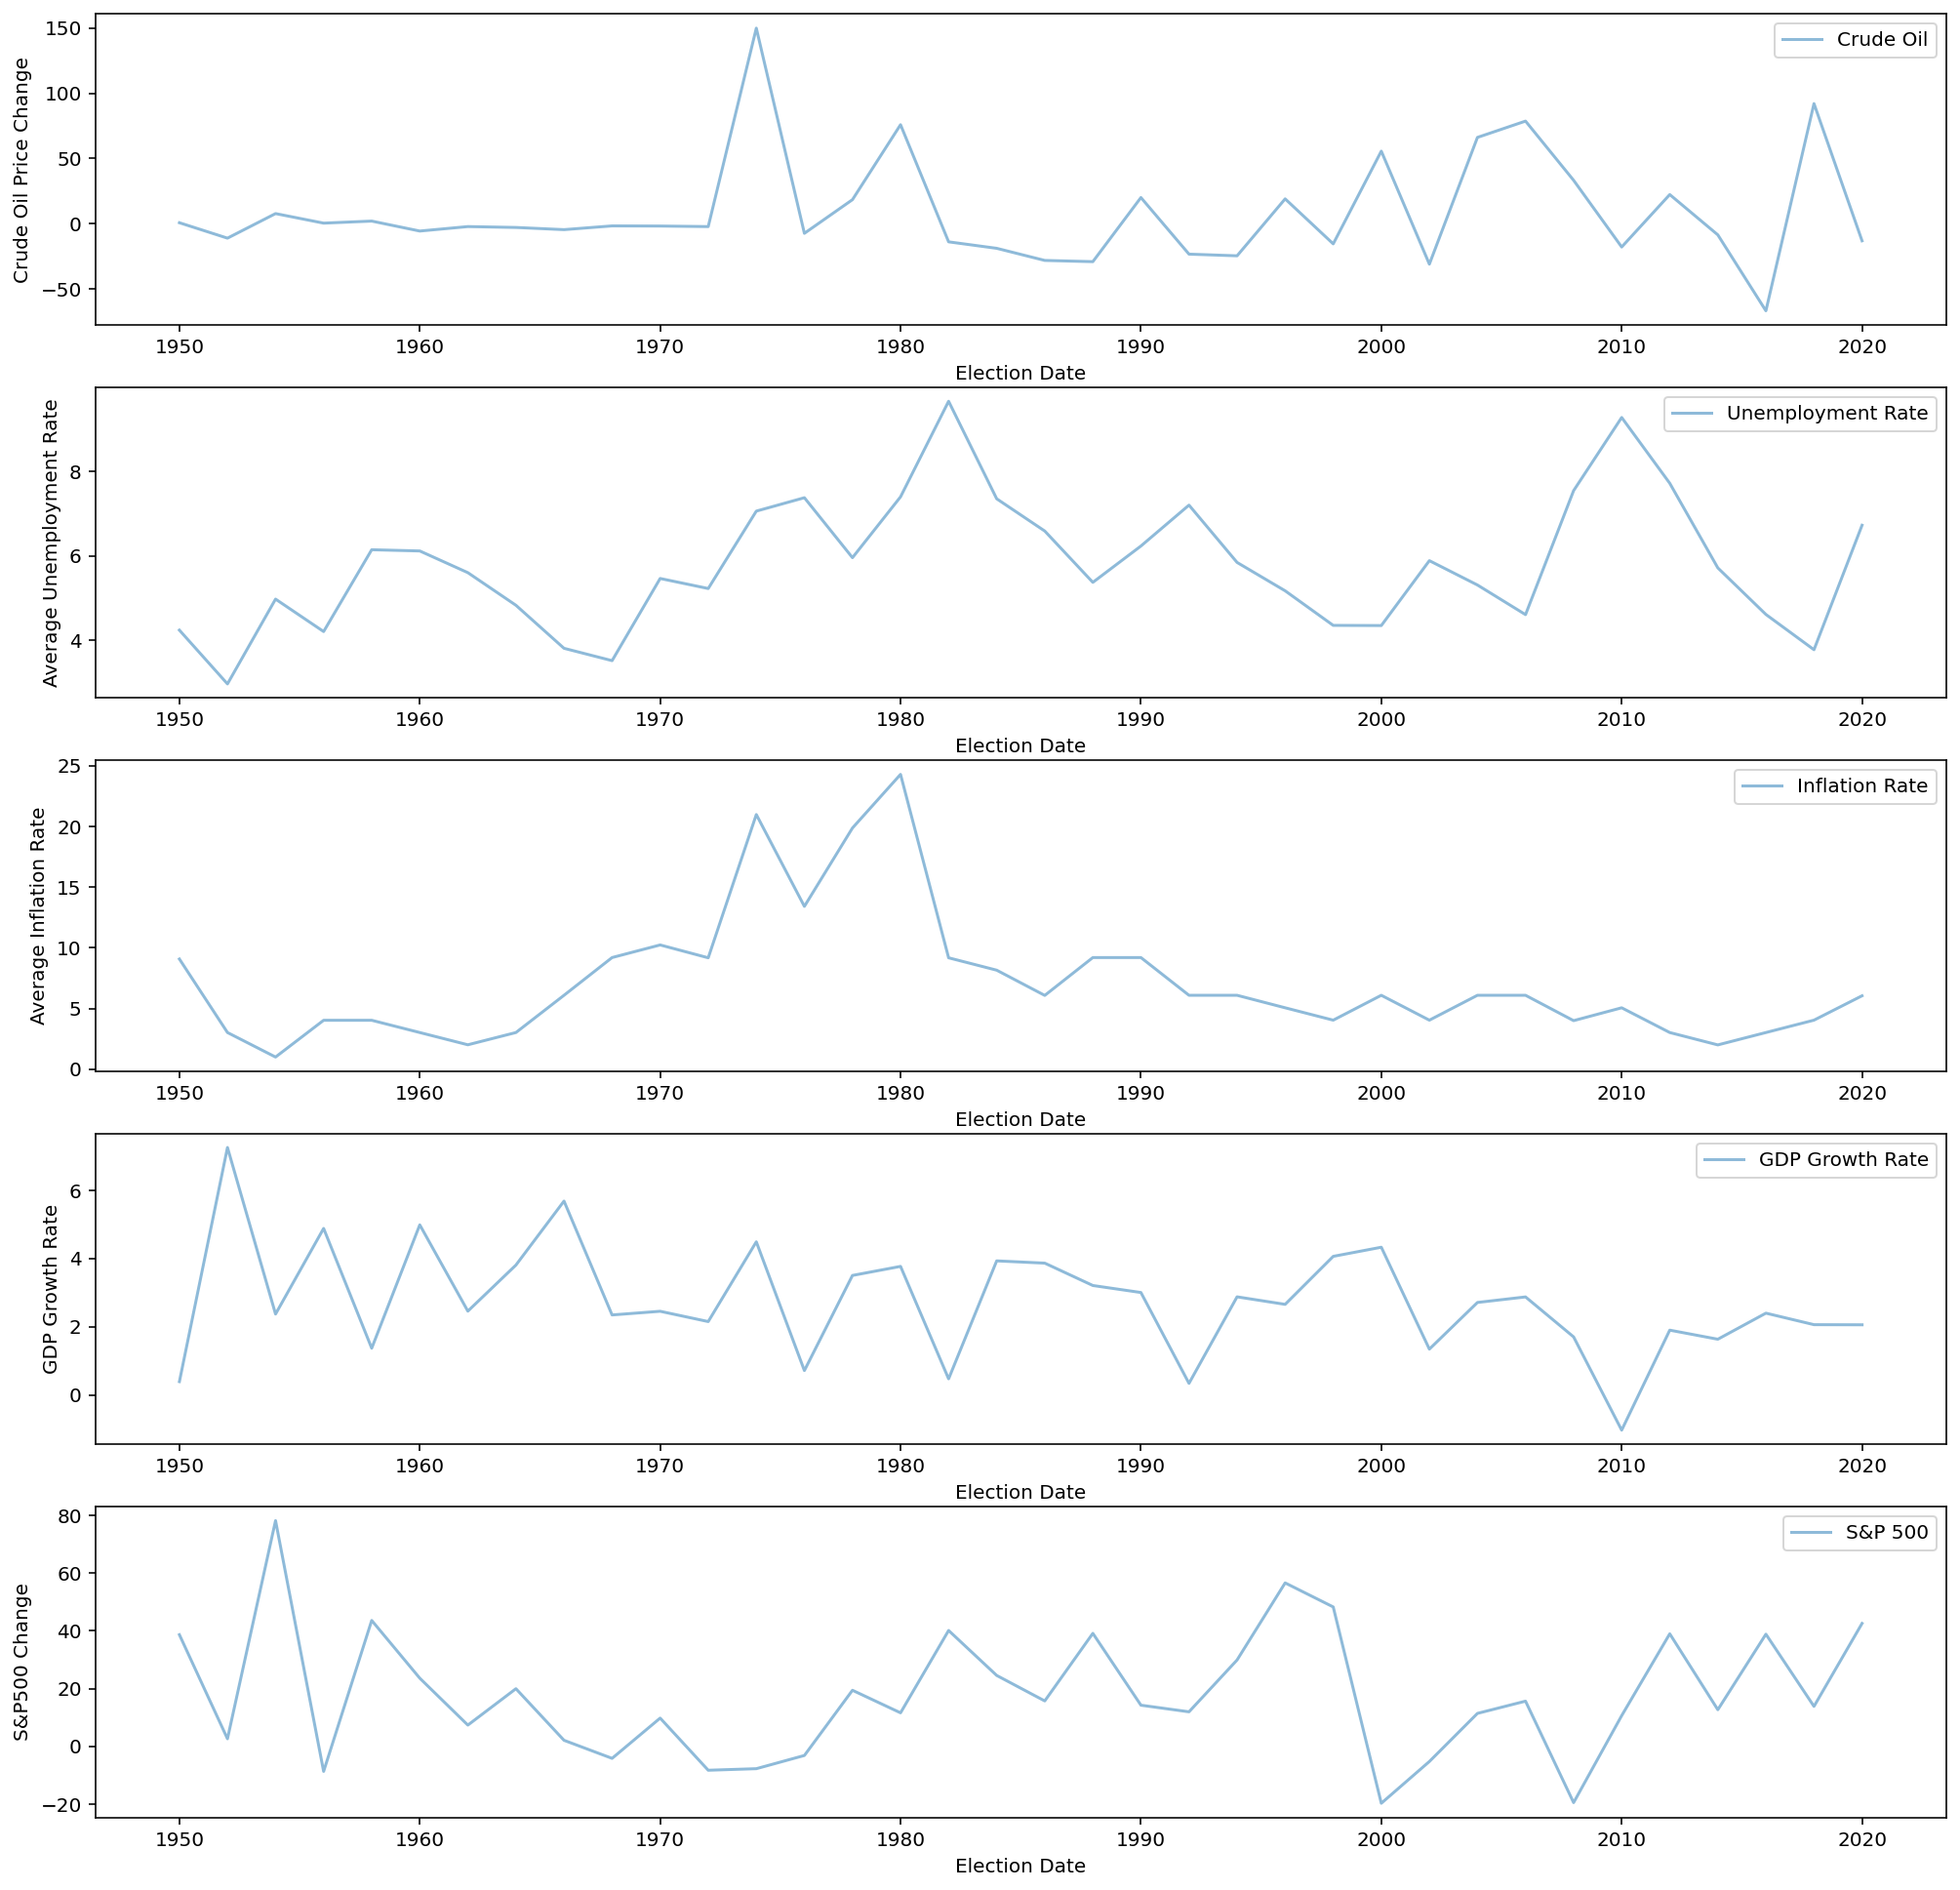

In [16]:
fig, axs = plt.subplots(5, figsize=(17,17))
sns.lineplot(ax = axs[0], x='Election Date', y='Crude Oil Price Change', alpha=0.5, data=df, label='Crude Oil')
sns.lineplot(ax = axs[1], x='Election Date', y='Average Unemployment Rate', alpha=0.5, data=df, label='Unemployment Rate')
sns.lineplot(ax = axs[2], x='Election Date', y='Average Inflation Rate', alpha=0.5, data=df, label='Inflation Rate')
sns.lineplot(ax = axs[3], x='Election Date', y='GDP Growth Rate', alpha=0.5, data=df, label='GDP Growth Rate')
sns.lineplot(ax = axs[4], x='Election Date', y='S&P500 Change', alpha=0.5, data=df, label='S&P 500')

<AxesSubplot:xlabel='S&P500 Change', ylabel='Count'>

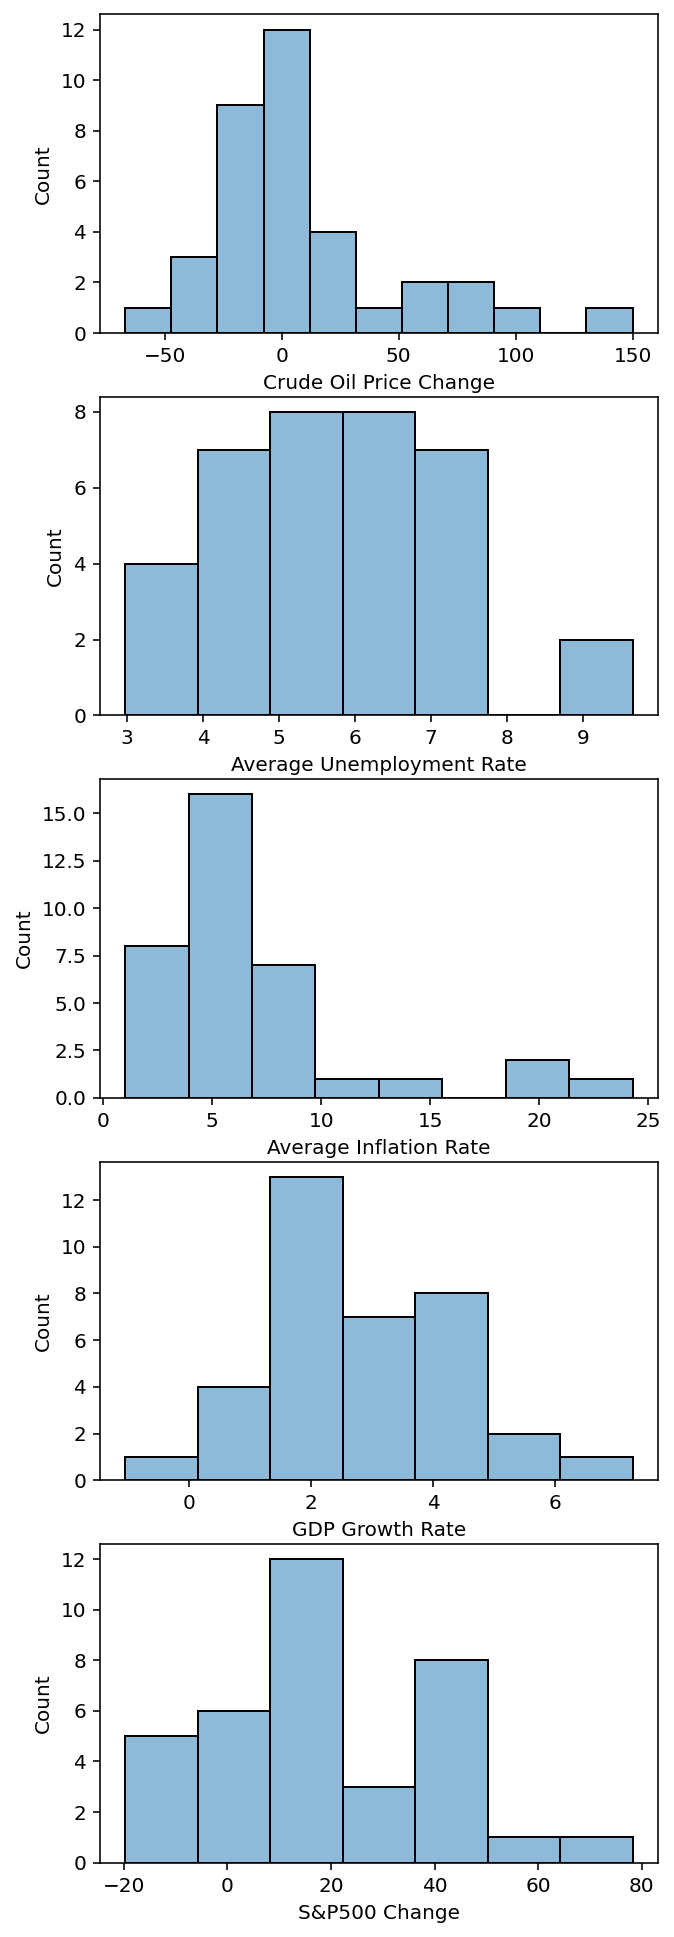

In [17]:
fig, axs = plt.subplots(5, figsize=(5,17))
sns.histplot(ax = axs[0], x='Crude Oil Price Change', alpha=0.5, data=df, label='Crude Oil')
sns.histplot(ax = axs[1], x='Average Unemployment Rate', alpha=0.5, data=df, label='Unemployment Rate')
sns.histplot(ax = axs[2], x='Average Inflation Rate', alpha=0.5, data=df, label='Inflation Rate')
sns.histplot(ax = axs[3], x='GDP Growth Rate', alpha=0.5, data=df, label='GDP Growth Rate')
sns.histplot(ax = axs[4], x='S&P500 Change', alpha=0.5, data=df, label='S&P 500')

From the histograms above, we can see the distributions of each of the variables. The variables for unemployment, GDP Growth rate, S&P500 appear to approach a mostly normal distribution with no significant outliers, but the distribution of crude oil price change and the average inflation rate are slightly left skewed. The crude oil and inflation distributions have a couple of outliers on the far right that make the distribution skew left. After eliminating the single outlier in the crude oil distribution, we can see the distribution is more like a normal distribution. For the inflation rate, we log transform the data, and the log-transformed data becomes more normally distributed.

(array([ 1.,  0.,  5., 10.,  9.,  4.,  1.,  1.,  2.,  2.]),
 array([-66.85175548, -50.95580583, -35.05985619, -19.16390655,
         -3.2679569 ,  12.62799274,  28.52394238,  44.41989202,
         60.31584167,  76.21179131,  92.10774095]),
 <BarContainer object of 10 artists>)

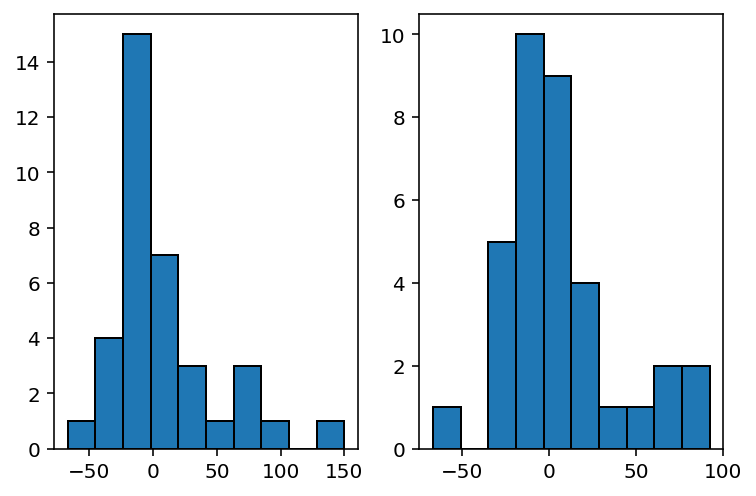

In [18]:
oil_price = df['Crude Oil Price Change']
max1 = max(oil_price)
index1 = oil_price[oil_price==max1].index
oil_price_changed = oil_price.drop(index1)
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(oil_price, edgecolor='black')
axs[1].hist(oil_price_changed, edgecolor='black')

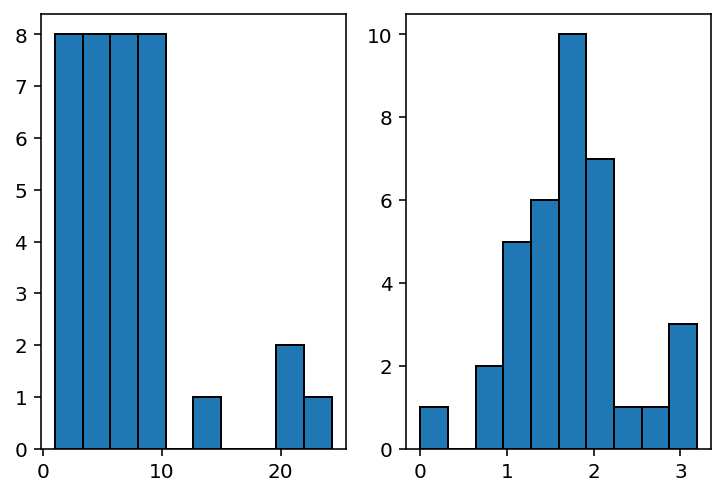

In [19]:
inflation = df['Average Inflation Rate']
log_inflation = np.log(df['Average Inflation Rate'])
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].hist(inflation, edgecolor='black')
axs[1].hist(log_inflation, edgecolor='black')
df['log_inflation'] = log_inflation

Now, we would combine all of those independt factors and see their relationships to each other.

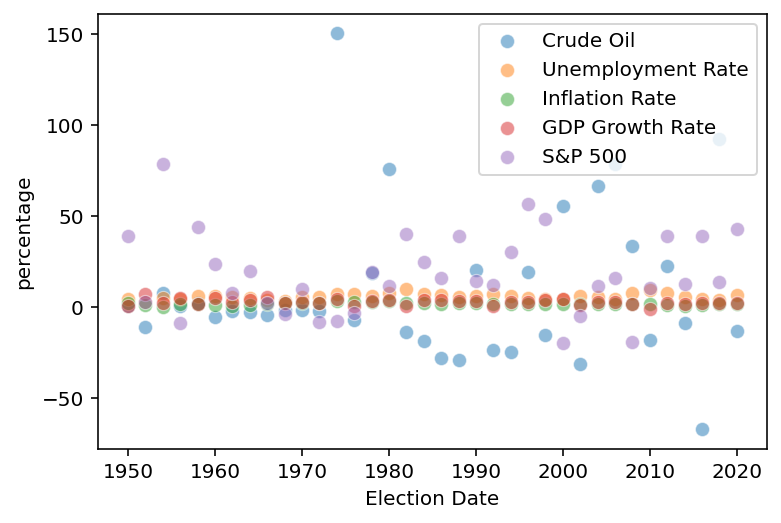

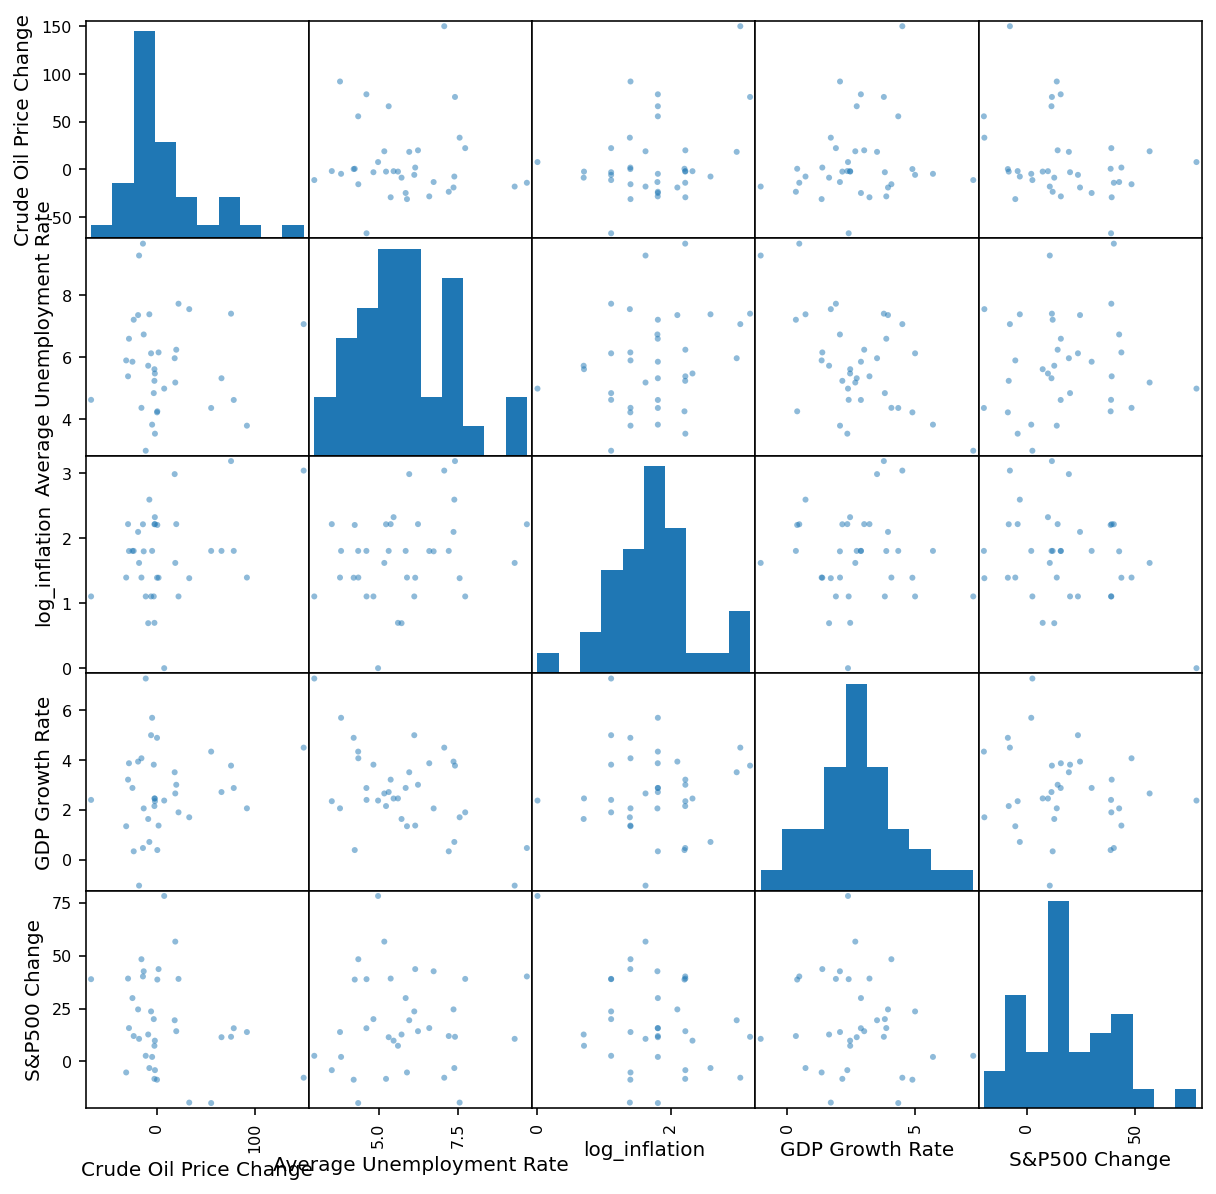

In [20]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

#TODO: Descibe, plot scatter plots with 5 independent variables as y axis, and year as x axis. Also, plot a barplot to see the distribution.
# We should write something to explain our steps and what we observe from plots or tables. Then, we can check the multicollinearity of our
# independent variables, and may use 

ax = sns.scatterplot(x='Election Date', y='Crude Oil Price Change', alpha=0.5, data=df, s=50, label='Crude Oil')
sns.scatterplot(x='Election Date', y='Average Unemployment Rate', alpha=0.5, data=df, s=50, ax=ax, label='Unemployment Rate')
sns.scatterplot(x='Election Date', y='log_inflation', alpha=0.5, data=df, s=50, ax=ax, label='Inflation Rate')
sns.scatterplot(x='Election Date', y='GDP Growth Rate', alpha=0.5, data=df, s=50, ax=ax, label='GDP Growth Rate')
sns.scatterplot(x='Election Date', y='S&P500 Change', alpha=0.5, data=df, s=50, ax=ax, label='S&P 500')
ax.set_ylabel("percentage")

fig = pd.plotting.scatter_matrix(df[['Crude Oil Price Change', 'Average Unemployment Rate', 'log_inflation',
                                     'GDP Growth Rate', 'S&P500 Change']], figsize=(10, 10))

After viewing the trend and distribution of all the five economic factors we are going to explore, we should check their relationships with the party seats change in the election year.

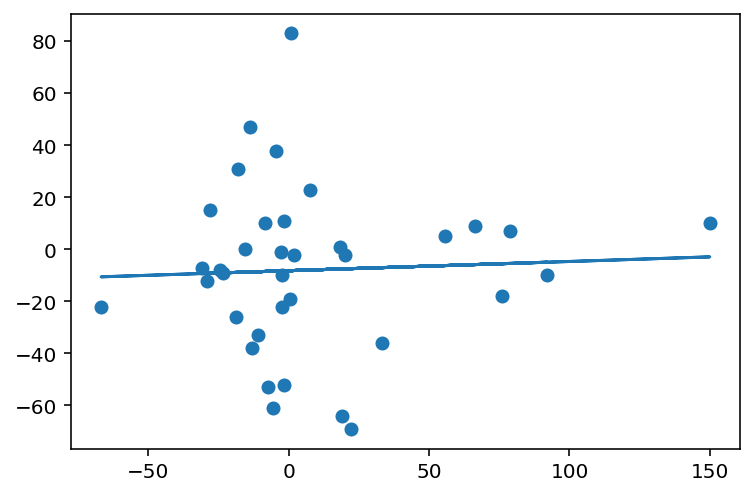

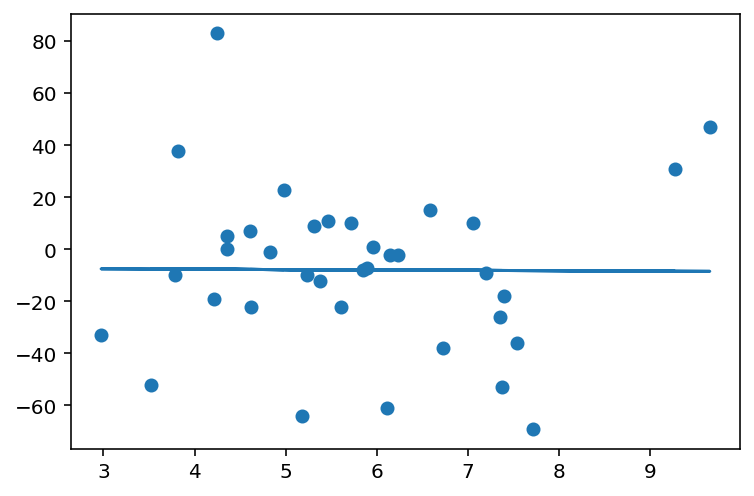

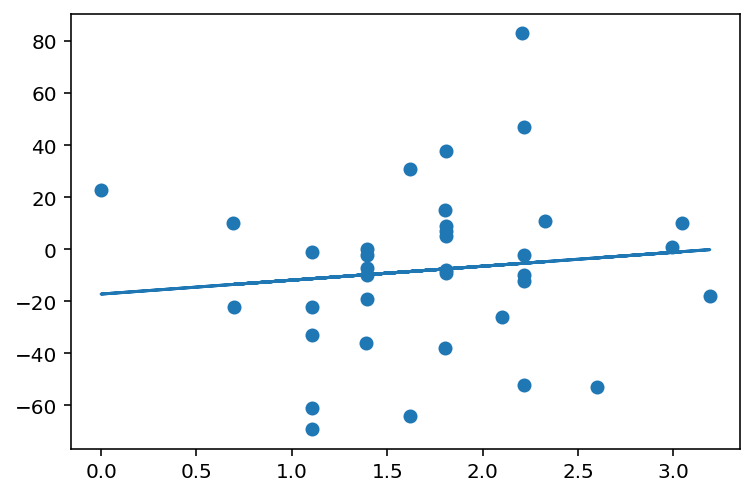

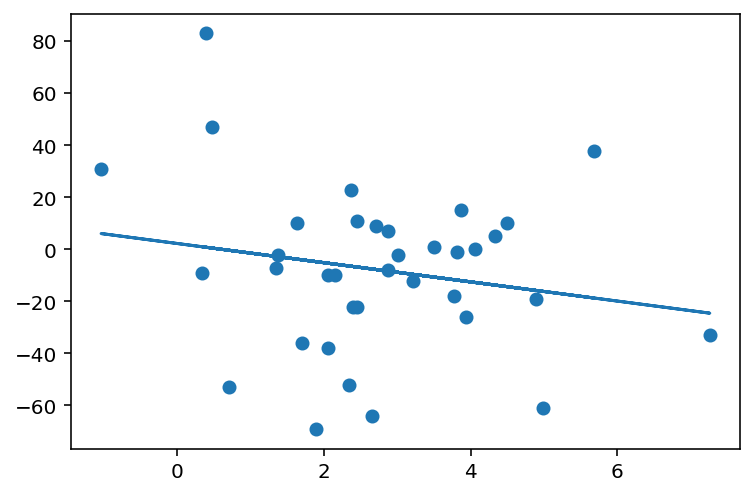

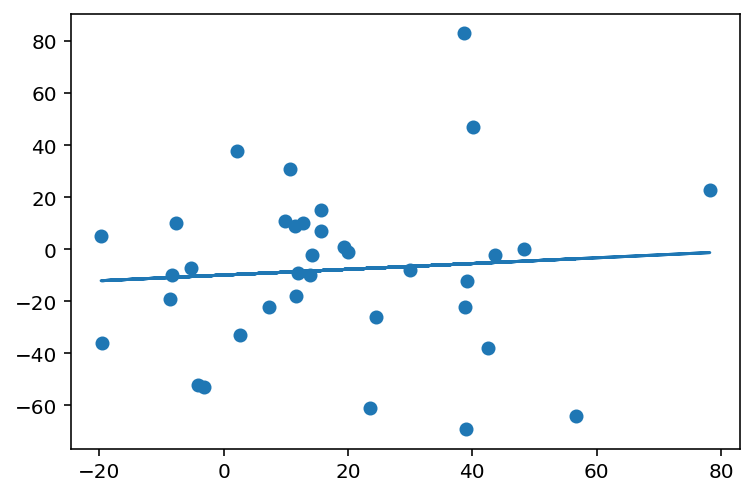

In [21]:
y = df['Party Seats Change of Incumbent Party'].tolist()
df['Party Seats Change of Incumbent Party'] = y

fig1 = plt.figure(1)
x = df['Crude Oil Price Change']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)

fig2 = plt.figure(2)
x = df['Average Unemployment Rate']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)

fig3 = plt.figure(3)
x = df['log_inflation']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)

fig4 = plt.figure(4)
x = df['GDP Growth Rate']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)

fig5 = plt.figure(5)
x = df['S&P500 Change']
a, b = np.polyfit(x, y, 1)
plt.scatter(x, y)
plt.plot(x, a*x+b)

plt.show()

From the graphs above, we can see that each of the factor slightly influence the party seats change in each election year. In order to better understanding their overall effect on party seats change, we are going to use a multiple linear regressional model.

In [37]:
df.columns = ['Election Date', 'Incumbent Party', 'SeatsChange', 'Oil', 'Unemployment', 'Inflation','GDP', 'SP500', 'log_inflation']

In [36]:
outcome, predictors = patsy.dmatrices('SeatsChange ~ Oil + Unemployment + GDP + SP500 + log_inflation', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            SeatsChange   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                 -0.062
Method:                 Least Squares   F-statistic:                    0.5895
Date:                Fri, 20 May 2022   Prob (F-statistic):              0.708
Time:                        20:59:42   Log-Likelihood:                -173.38
No. Observations:                  36   AIC:                             358.8
Df Residuals:                      30   BIC:                             368.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        14.5835     33.812      0.431

From the regressional model above, we can see that the change of crude oil price and S&P500 have minimum influence in the party seats change. We also need to check about the mulitcollinearity of the model.

In [47]:
X = df[['Oil','Unemployment','Inflation' ,'GDP', 'SP500',]]
vif_df = pd.DataFrame()
vif_df["feature"] = X.columns
vif_df["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_df

,feature,VIF
0,Oil,1.395372
1,Unemployment,5.308420
2,Inflation,4.157777
3,GDP,2.587287
4,SP500,1.806283


From the vif table above, we can see that all the independent variables have a moderate correlations with each other, and it is reasonable since they are all related to economy. However, those correlations are not very strong, so we can still think they is not a multicollinearity among the variables. In addition, since the vif of unemployment is over 5, we should be careful about it.